In [1]:
#Packages for preprocessing
import pandas as pd
import random
import numpy as np
from sklearn.utils import shuffle
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical


#Packages for model traning and testing
from keras import models
from keras import layers
from keras import regularizers
import matplotlib.pyplot as plt



Using Theano backend.


In [2]:
with open('final_text.txt','rb') as file:
    text = file.read().decode(errors='replace')


In [3]:
questions_df = pd.read_csv('question-pairs-dataset/questions.csv')     #reading questions from questions.csv
questions_data = list(questions_df['question1'])                       #taking only the column of questions
questions_data = questions_data[:10664]                                #taking a slice as the other dataset has only 10664 entries

In [4]:
with open('positive-and-negative-sentences/positive.txt','rb') as file:
    data_pos = file.read().decode(errors='replace')     #positive comments
data_pos = data_pos.split('\n')                         #split based on new line
with open('positive-and-negative-sentences/negative.txt','rb') as file:
    data_neg = file.read().decode(errors='replace')     #negative comments
data_neg = data_neg.split('\n')                         #split based on new line

In [5]:
non_questions_data = data_pos+data_neg                  #combine
random.shuffle(non_questions_data)                      #shuffle

In [6]:
questions_data_labels = list(np.ones(len(questions_data)))                  #target vectors for question and non question data
non_questions_data_labels = list(np.zeros(len(non_questions_data)))

In [7]:
X = questions_data + non_questions_data
Y = questions_data_labels + non_questions_data_labels
X,Y = shuffle(X,Y,random_state=1)                      #shuffling X and Y 



In [8]:
X = np.array(X)
Y = np.array(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=31) #split testing and training set
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 19195
# Test data samples: 2133


In [9]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary

In [10]:
tk = Tokenizer(num_words=NB_WORDS,                            #defining tokenizer which tokenizes sentences into
               filters='!"#$%&()*+,-./:;<=>@[\\]^_`{|}~\t\n', #words. Note that we do not filter out ''?'.
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)
X_train_seq = tk.texts_to_sequences(X_train)                  #convert texts to sequences(based on incices)
X_test_seq = tk.texts_to_sequences(X_test)


In [11]:
seq_lengths = pd.Series(X_train).apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

#We check what is the maximum length of sequence, so that we can pad zeros for the rest sequences, as the input length has to be constant

count    19195.000000
mean        16.556187
std          9.591175
min          1.000000
25%          9.000000
50%         14.000000
75%         23.000000
max         66.000000
dtype: float64

In [12]:
MAX_LEN = 44  # Maximum number of words in a sequence. We truncate if more than this.

In [13]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)   #pad zeros
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [14]:
X_train_seq_trunc[10]  # Example of padded sequence

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0, 9461,  341,   17,    1, 7341,   27,    3,    1,  646, 3111],
      dtype=int32)

In [15]:
print(y_train)   #example of label

[0. 0. 0. ... 0. 1. 1.]


In [16]:
le = LabelEncoder()
y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)

In [17]:
print(y_train_oh)   #example of label after one hot encoding

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [18]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.1, random_state=37)

#separating validation set from training set

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

#checking if dimensions are same for training and testing shape

print('Shape of validation set:',X_valid_emb.shape)

Shape of validation set: (1920, 44)


In [19]:
GLOVE_DIM = 100  # Number of dimensions of the GloVe word embeddings

In [20]:
glove_file = 'glove.twitter.27B.' + str(GLOVE_DIM) + 'd.txt'    #glove file containing words and glove vectors
emb_dict = {}
glove = open('glove.twitter.27B/'+ glove_file)
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

#Constructing embedding mastrix

emb_matrix = np.zeros((NB_WORDS, GLOVE_DIM))

for w, i in tk.word_index.items():
    # The word_index contains a token for all words of the training data so we need to limit that
    if i < NB_WORDS:
        vect = emb_dict.get(w)
        # Check if the word from the training data occurs in the GloVe word embeddings
        # Otherwise the vector is kept with only zeros
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break

In [21]:
glove_model = models.Sequential()
glove_model.add(layers.Embedding(NB_WORDS, GLOVE_DIM, input_length=MAX_LEN))
glove_model.add(layers.LSTM(200, dropout_U = 0.2, dropout_W = 0.2))
glove_model.add(layers.Dense(2, activation='softmax'))
glove_model.summary()

/home/mayank/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, dropout=0.2, recurrent_dropout=0.2)`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mayank/.local/lib/python3.7/site-packages/keras/layers/recurrent.py:2155: UserWarning: RNN dropout is no longer supported with the Theano backend due to technical limitations. You can either set `dropout` and `recurrent_dropout` to 0, or use the TensorFlow backend.
  'RNN dropout is no longer supported with the Theano backend '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 44, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 402       
Total params: 1,241,202
Trainable params: 1,241,202
Non-trainable params: 0
_________________________________________________________________


In [22]:
glove_model.layers[0].set_weights([emb_matrix])
glove_model.layers[0].trainable = False             #we are using pretrained weights. No need to train the initial layer

In [23]:
NB_START_EPOCHS = 10  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent


In [24]:
glove_model.compile(optimizer='rmsprop'                   #defining the model's training configs
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    

In [25]:

glove_history = glove_model.fit(X_train_emb                               #training the model
                       , y_train_emb
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid_emb, y_valid_emb)
                       , verbose=1)

glove_history.history['acc'][-1]

Train on 17275 samples, validate on 1920 samples
Epoch 1/10
17275/17275 [==============================] - 28s 2ms/step - loss: 0.2957 - acc: 0.8772 - val_loss: 0.1476 - val_acc: 0.9526
Epoch 2/10
17275/17275 [==============================] - 29s 2ms/step - loss: 0.1294 - acc: 0.9539 - val_loss: 0.1263 - val_acc: 0.9542
Epoch 3/10
17275/17275 [==============================] - 28s 2ms/step - loss: 0.0925 - acc: 0.9670 - val_loss: 0.1195 - val_acc: 0.9562
Epoch 4/10
17275/17275 [==============================] - 29s 2ms/step - loss: 0.0809 - acc: 0.9705 - val_loss: 0.0747 - val_acc: 0.9750
Epoch 5/10
17275/17275 [==============================] - 30s 2ms/step - loss: 0.0636 - acc: 0.9756 - val_loss: 0.0604 - val_acc: 0.9755
Epoch 6/10
17275/17275 [==============================] - 33s 2ms/step - loss: 0.0539 - acc: 0.9790 - val_loss: 0.0708 - val_acc: 0.9708
Epoch 7/10
17275/17275 [==============================] - 35s 2ms/step - loss: 0.0504 - acc: 0.9814 - val_loss: 0.0567 - val_acc:

0.9880173656219339

In [26]:
def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()



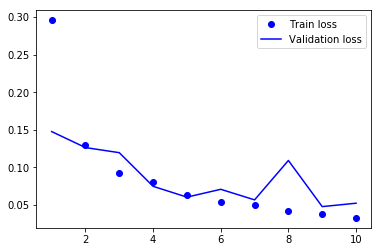

In [27]:
eval_metric(glove_history, 'loss')                    #Loss during traning vs validation

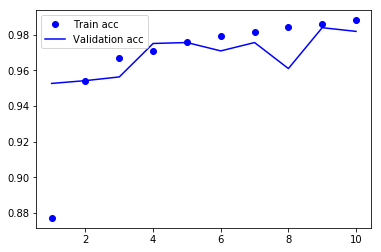

In [28]:
eval_metric(glove_history, 'acc')                     #Accuracy during traning vs validation


In [29]:

glove_model.fit(X_train_seq_trunc
              , y_train_oh
              , epochs=3
              , batch_size=BATCH_SIZE
              , verbose=0)
glove_results = glove_model.evaluate(X_test_seq_trunc,y_test_oh)
print('/n')
print('Test accuracy of word glove model: {0:.2f}%'.format(glove_results[1]*100))

2133/2133 [==============================] - 3s 1ms/step
/n
Test accuracy of word glove model: 98.59%


In [30]:
def predict_if_question(sentence):
    sentence_nstop = [sentence]
    sentence_nstop = np.array(sentence_nstop)
    sentence_seq = tk.texts_to_sequences(sentence_nstop)
    #print(sentence_seq)
    sentence_seq_trunc = pad_sequences(sentence_seq, maxlen=MAX_LEN)
    return glove_model.predict(sentence_seq_trunc)

In [31]:
import segment
res = segment.get_list()
res

Instructions for updating:
Colocations handled automatically by placer.


From /home/mayank/.local/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Using char embeddings

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


From /home/mayank/.local/lib/python3.7/site-packages/seqtag/ner_model.py:140: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API


From /home/mayank/.local/lib/python3.7/site-packages/seqtag/ner_model.py:145: bidirectional_dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API


Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


From /home/mayank/.local/lib/python3.7/site-packages/tensorflow/python/ops/rnn.py:443: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


Instructions for updating:
Use tf.cast instead.


From /home/mayank/.local/lib/python3.7/site-packages/tensorflow/python/ops/rnn.py:626: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


From /home/mayank/.local/lib/python3.7/site-packages/seqtag/ner_model.py:156: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
/home/mayank/.local/lib/python3.7/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
Initializing tf session
Reloading the latest trained model...


Instructions for updating:
Use standard file APIs to check for files with this prefix.


From /home/mayank/.local/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from deepsegment_eng_v1/deepsegment_eng_v1/model.weights/


Restoring parameters from deepsegment_eng_v1/deepsegment_eng_v1/model.weights/


Completed loading the model


['yeah its small size',
 'font people are giving comments about the type of problems anything else smaller frontier',
 'i got back and a background',
 'color is is horrible right ardiss',
 'no contrast correct so somebody is pointing out different things right unable to read so these are two problems',
 'how many people find that this position of the logo is also not very correct',
 'it is chopped from the top item on the logo should be seen complete and you should be able to read it right then how the people are scared of this a hundred and thirty seven slides like this',
 'can you withstand such a presentation for so long',
 'its not correct right here',
 'somebody from gray mentioned it is not correct therefore we cannot read it as it is horrible so i was joking',
 'actually i wanted to show how bad presentation slides can really ruin the content therefore i deliberately started with a bad slide all of you',
 'can you read this slide now',
 'how is this light so i am going to talk a

In [37]:
file_5 = open("questions_0.5.txt","w")
file_6 = open("questions_0.6.txt","w")
file_7 = open("questions_0.7.txt","w")
file_8 = open("questions_0.8.txt","w")
file_9 = open("questions_0.9.txt","w")
file_95 = open("questions_0.95.txt","w")

In [38]:

for i in res:
    acc = predict_if_question(i)
    print(i,":",acc)
    if(acc[0][1]>0.5):
        file_5.write(i+"\n")
    if(acc[0][1]>0.6):
        file_6.write(i+"\n")
    if(acc[0][1]>0.7):
        file_7.write(i+"\n")
    if(acc[0][1]>0.8):
        file_8.write(i+"\n")
    if(acc[0][1]>0.9):
        file_9.write(i+"\n")
    if(acc[0][1]>0.95):
        file_95.write(i+"\n")
    


yeah its small size : [[0.80583197 0.19416805]]
font people are giving comments about the type of problems anything else smaller frontier : [[0.2929825 0.7070175]]
i got back and a background : [[0.71215415 0.28784582]]
color is is horrible right ardiss : [[5.7616584e-05 9.9994236e-01]]
no contrast correct so somebody is pointing out different things right unable to read so these are two problems : [[0.8835189  0.11648111]]
how many people find that this position of the logo is also not very correct : [[0.00863819 0.9913618 ]]
it is chopped from the top item on the logo should be seen complete and you should be able to read it right then how the people are scared of this a hundred and thirty seven slides like this : [[9.9998134e-01 1.8683346e-05]]
can you withstand such a presentation for so long : [[0.0242185 0.9757815]]
its not correct right here : [[0.98590475 0.01409527]]
somebody from gray mentioned it is not correct therefore we cannot read it as it is horrible so i was joking : 

if we dont have a story element in anything what we are here we communicate for example when i started with that presentation which had no color and very badly use fonts : [[0.9845482 0.0154518]]
i suddenly had communication from all of you saying that we cant read it and that has struck my communication right : [[0.9938936  0.00610639]]
now i am talking to you instead of you sitting there and listening to me and silently you are equally participating in this presentation and that makes my point very easy to communicate now : [[0.90911525 0.09088472]]
i am communicating am not preaching like one person just saying something and other suggests a passive listening to it : [[0.75127167 0.24872836]]
thats not the case so in order to achieve that we need a story in every explanation what were trying to make i dont mean that you have to always talk about be king and queen and all that but you need to connect with people with some interesting thing and what is the story typically so if you an

if i show you this mind map directly the same guidelines are explained using this and this becomes more user friendly for people to understand so you can use a link you can use color you can emphasize and add images and you can have various dimensions to it : [[0.00568218 0.9943178 ]]
you can use keywords and use of apparent over will help in giving importance there can be different styles : [[4.1343836e-05 9.9995863e-01]]
you can have a personal style can develop from original sin which is available and all sorts of things so this is pretty easy to remember because of the structure itself as compared to this ten bullet slide : [[9.9995321e-01 4.6764795e-05]]
this becomes very easy even if i have asked this question to lot of people later on and they are able to recollect a lot of these guidelines just looking at this mindmap as compared to the presentation slides right so let us move on but before that i think there was a a question in the last class which had given that what is the d

i would like to stop here for this particular topic and i would like to a now tell you about the activity you are going to do today and are in between if there are some questions i would like to take those questions please : [[7.5430865e-04 9.9924570e-01]]
we wanted you know like i have a downloaded pun people long back : [[0.84989965 0.15010037]]
i dont know the credit : [[0.49103227 0.5089677 ]]
how can i get credit so the question has done okay so i will repeat the person you are saying that you have downloaded some powerpoint slides from internet and you dont know the source of that : [[9.271243e-05 9.999073e-01]]
is it correct : [[0.10690461 0.8930954 ]]
so how will you give credit for that presentation the website wherever you have downloaded from is also one of the ways you can referred me back so if you have downloaded from for example slideshare you will come to know that it has been uploaded by ex login name you can refer to that name and that is also good enough because some

you cannot see white text on white so use of background is very important and at times your to take a very clear call about whether you require a background or not that is the thing that week i decided that will focus on these aspects in this small little module about visual communication using text and graphics while i would like to take you back to a smaller but very important component of a presentation which is the process and typically it should start with the planning phase where you plan a presentation : [[0.02299772 0.97700226]]
i am sure it is nothing to do with your visual graphic sense but planning a presentation is very important : [[0.99307555 0.00692448]]
after you plan then you can decide : [[0.7955358  0.20446418]]
how do you want to execute it : [[3.2423736e-04 9.9967575e-01]]
like what is the outline : [[0.03172405 0.96827596]]
what are the details of a bullets : [[3.7432947e-06 9.9999624e-01]]
youre going to add all that and finally you decide on the template which w

i there is one option that you just count them : [[0.88203    0.11796997]]
then there is one a and seeks is to see and all that and then you can also bring it back white : [[0.99753803 0.00246198]]
there is one option : [[0.68990594 0.31009403]]
there is another option where you can create some words meaningful words right so this is one couple of words we can create and infact we can also create a sentence out of it what the sentence say a coincedence re merging unspent but tell me frankly hobby people can remember the sentence very difficult right so let me give you another sentence : [[9.9977231e-01 2.2769328e-04]]
can you remember the sentence a coincedence emergent nursing can remember this well : [[0.500714   0.49928597]]
even this is very difficult eye or if i give you computer science and engineering will that would be a pretty easy to remember for most of you because they are associated with this department or acne they see this nameplate outside everywhere so its not a very f

people are the same brush after even after another but yeah can you be more specific : [[0.15438673 0.8456133 ]]
you cannot be specific because i have not given you the context and thats why all the answers are ringing in the zone of just a brush because women as a bristles and a cleaning you remember a brush right now depends on the content very correctly said by college of engineering in good to add that it depends on the context : [[0.96393025 0.03606975]]
i suppose i give your context well so i give your context that i want something for teeth something for face and something for people know what will you use for teeth : [[5.6442776e-04 9.9943554e-01]]
obviously you will use the toothbrush i and what will use for face that would be be shaving brush and was of the women in the audience used to be the answer that they would use a makeup brush which is also correct a and a fight of our paper or a wall or something then that would be the painting rests also depends on the context that 

In [39]:
file_5.close()
file_6.close()
file_7.close()
file_8.close()
file_9.close()
file_95.close()

In [37]:
predict_if_question("Do you?")

array([[0.04552053, 0.95447946]], dtype=float32)

In [38]:
predict_if_question("You are going to the park arent you")

array([[0.15338263, 0.84661734]], dtype=float32)

In [39]:
predict_if_question("Do you?")

array([[0.04552053, 0.95447946]], dtype=float32)

In [43]:
predict_if_question("explain about telecom industry")

array([[0.58534485, 0.41465515]], dtype=float32)

In [42]:
predict_if_question("i was explaining about telecom industry")

array([[0.81078756, 0.18921246]], dtype=float32)